In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

! ls -lh /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/RData2csv/immuno

total 416K
drwxrwsr-x 2 was966 zitnik 256 Aug 18 11:43 dat.Chen.RData
drwxrwsr-x 2 was966 zitnik 395 Aug 18 11:43 dat.Cho.RData
drwxrwsr-x 2 was966 zitnik 487 Aug 18 11:43 dat.Gide.RData
drwxrwsr-x 2 was966 zitnik 478 Aug 18 11:43 dat.Huang.RData
drwxrwsr-x 2 was966 zitnik 481 Aug 18 11:43 dat.Hwang.RData
drwxrwsr-x 2 was966 zitnik 395 Aug 18 11:43 dat.Kim.RData
drwxrwsr-x 2 was966 zitnik 597 Aug 18 11:44 dat.Liu.RData
drwxrwsr-x 2 was966 zitnik 660 Aug 18 11:44 dat.Miao.RData
drwxrwsr-x 2 was966 zitnik 369 Aug 18 11:44 dat.Nathanson_pre.RData
drwxrwsr-x 2 was966 zitnik 721 Aug 18 11:44 dat.Prat.RData
drwxrwsr-x 2 was966 zitnik 453 Aug 18 11:44 dat.Riaz.RData
drwxrwsr-x 2 was966 zitnik 569 Aug 18 11:44 dat.Snyder.RData
drwxrwsr-x 2 was966 zitnik 476 Aug 18 11:44 dat.VanAllen.RData


### Sample table

In [20]:
dfp = pd.read_csv('./raw/Hugo_raw_clinical.csv', index_col = 'Patient ID')
dfp = dfp[dfp.RNAseq == 1]
# only grab the pre-treatment samples
dfp = dfp[dfp['Biopsy Time'] == 'pre-treatment']

In [21]:
dfp = dfp.loc[dfp.index.dropna()]

In [22]:
response_flag = {'Progressive Disease': 0, 'Partial Response':1, 'Complete Response':1}
dfp['flag'] = dfp.irRECIST.map(response_flag)
dfp.index.name = 'samples'
dfp = dfp.rename(columns={'Age':'age', 'Gender':'gender', 
                    'irRECIST':'response', 'Disease Status':'stage', 'Vital Status': 'status',
                   'Overall Survival':'survival', 'Treatment':'treatment', 'Study site':'study'})

In [23]:
cols = ['flag', 'response', 'age', 'gender', 'treatment', 'stage', 'survival', 'status',
        'treatment', 'study', 'Biopsy Time','SRA Run ID, tumor RNA','Accession ID, RNAseq']
df_samples = dfp[cols]

In [33]:
df_samples.flag.value_counts()

flag
1    14
0    12
Name: count, dtype: int64

## calculate TMB

In [8]:
dfp.columns

Index(['response', 'study', 'gender', 'age', 'stage', 'survival', 'status',
       'Previous MAPKi', 'Anatomical Location', 'BRAF', 'NRAS', 'NF1',
       'treatment', 'Biopsy Time', 'WES', 'RNAseq', 'SRA Run ID, tumor WES',
       'SRA Run ID, normal WES', 'AccessionID, WES', 'SRA Run ID, tumor RNA',
       'Accession ID, RNAseq', 'flag'],
      dtype='object')

### Mutation table

In [9]:
captureSize = 35.8 #for tmb claculation

VC_NONSYNONYMOUS_LIST = ['Frame_Shift_Del',
                         'Frame_Shift_Ins',
                         'In_Frame_Del',
                         'In_Frame_Ins',
                         'Missense_Mutation',
                         'Nonsense_Mutation',
                         'Splice_Site',
                         'Nonstop_Mutation',
                         'Splice_Region']

truncate_mut_LIST = ['Nonsense_Mutation', 'Frame_Shift_Ins','Frame_Shift_Del','Splice_Site']
nontruncate_mut_LIST = ['Missense_Mutation','In_Frame_Del', 'In_Frame_Ins','Nonstop_Mutation']

mut = pd.read_csv('./raw/data_mutations.txt',sep='\t')

mut['nansynonymous_mut_flag'] = mut.Variant_Classification.isin(VC_NONSYNONYMOUS_LIST)
mut['truncate_mut_flag'] = mut.Variant_Classification.isin(truncate_mut_LIST)
mut['nontruncate_mut_flag'] = mut.Variant_Classification.isin(nontruncate_mut_LIST)

In [10]:
mut.Variant_Classification.value_counts()

Variant_Classification
Missense_Mutation         23374
Nonsense_Mutation          1380
Intron                      372
Splice_Site                 354
RNA                         252
Silent                      153
3'Flank                      86
5'Flank                      85
3'UTR                        63
5'UTR                        62
Translation_Start_Site       37
IGR                          19
Splice_Region                15
Nonstop_Mutation             12
Name: count, dtype: int64

In [11]:
I_calculated_TMB1 = mut.groupby('Tumor_Sample_Barcode').nansynonymous_mut_flag.sum()
I_calculated_TMB2 = mut.groupby('Tumor_Sample_Barcode').apply(lambda x:x.truncate_mut_flag.sum()*2+x.nontruncate_mut_flag.sum())

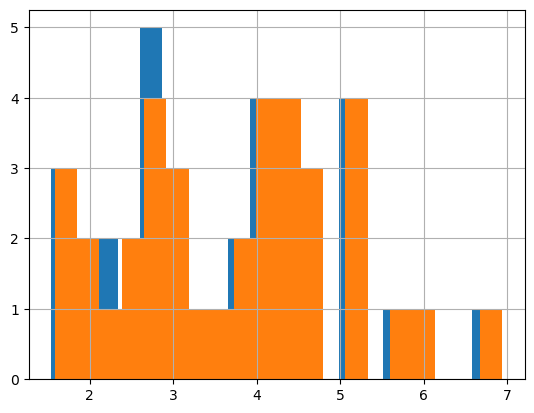

In [12]:
#for tmb claculation
tmb1 = np.log2(I_calculated_TMB1/captureSize)
tmb2 = np.log2(I_calculated_TMB2/captureSize)

tmb1.hist(bins=20)
tmb2.hist(bins=20)

tmb = tmb1.to_frame('tmb.dan').join(tmb2.to_frame(name = 'tmb.wang'))
df_samples = df_samples.join(tmb)

In [13]:
df_samples.flag.value_counts()

flag
1    14
0    12
Name: count, dtype: int64

In [14]:
df_samples = df_samples[~df_samples.flag.isna()]
df_samples.to_csv('./processed/samples.csv')

In [15]:
df_samples.head(3)

,flag,response,age,gender,treatment,stage,survival,status,treatment,study,Biopsy Time,"SRA Run ID, tumor RNA","Accession ID, RNAseq",tmb.dan,tmb.wang
samples,,,,,,,,,,,,,,,
Pt1,0,Progressive Disease,66.0,F,Pembrolizumab,M1b,607.0,Dead,Pembrolizumab,UCLA,pre-treatment,SRR3184279,GSE78220,5.722283,5.792309
Pt2,1,Partial Response,55.0,M,Pembrolizumab,M1c,927.0,Alive,Pembrolizumab,UCLA,pre-treatment,SRR3184280,GSE78220,5.840224,5.929548
Pt4,1,Partial Response,62.0,M,Pembrolizumab,M1c,948.0,Alive,Pembrolizumab,UCLA,pre-treatment,SRR3184281,GSE78220,6.841279,6.937131


### mRNA table

In [16]:
df_fpkm = pd.read_excel('./raw/GSE78220_PatientFPKM.xlsx',index_col=0)
df_fpkm.columns = df_fpkm.columns.map(lambda x:x.split('.')[0])
df_fpkm = df_fpkm.rename(columns={'Pt27A':'Pt27'})
df_fpkm = df_fpkm[df_samples.index]
df_fpkm.shape

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(25268, 26)

In [17]:
def fpkm2tpm(fpkm_matrix):
    '''
    fpkm_matrix: rows: genes, columns: samples/patients
    '''
    _fpkm2tpm = lambda fpkm: np.exp(np.log(fpkm) - np.log(np.sum(fpkm)) + np.log(1e6))
    tpm_matrix = fpkm_matrix.apply(_fpkm2tpm, axis=0)
    return tpm_matrix

In [18]:
df_tpm = fpkm2tpm(df_fpkm)
df_tpm.to_csv('./processed/abundance.csv')

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df_tpm

,Pt1,Pt2,Pt4,Pt5,Pt6,Pt7,Pt8,Pt9,Pt10,Pt12,...,Pt23,Pt25,Pt27,Pt28,Pt29,Pt31,Pt32,Pt35,Pt37,Pt38
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,2.121973,67.192887,0.959827,11.323212,0.216408,2.309156,2.019860,2.091944,0.781439,0.762204,...,1.007920,4.275322,1.741514,1.560170,0.737340,18.413167,32.991602,23.002131,17.962034,7.213945
A1BG-AS1,0.179137,6.003933,0.078725,0.573827,0.027927,0.955775,0.684468,0.651324,0.344153,0.561863,...,0.069143,0.046756,0.075953,0.238628,0.426062,0.316915,1.278165,1.419166,0.465292,0.409411
A1CF,0.000000,3.831379,0.000000,0.000000,0.001561,0.000000,0.000580,0.000359,0.000000,0.000000,...,0.000130,0.000000,0.000000,0.034163,0.001285,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,48.995825,96.297520,13.528768,68.357286,18.847182,4.782955,21.142225,59.673226,90.192838,62.093576,...,19.772066,31.826428,111.541395,12.181273,75.348716,62.797459,230.758194,110.058089,47.499409,798.189910
A2M-AS1,0.096120,0.606028,0.033616,0.067384,0.057778,0.111301,0.555306,1.081466,0.267838,0.218813,...,0.093102,0.265677,0.113661,0.113928,0.174901,0.160840,1.564891,0.341243,1.900597,1.691916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.001983,0.011603,0.000000,0.000000,0.000000,0.221276,0.000000,0.001760,0.004087,0.001172,...,0.003131,0.001967,0.001064,0.011300,0.012302,0.054970,0.118375,0.088553,0.023916,0.206308
ZYG11B,1.930710,1.187046,0.668649,9.335782,0.806179,0.486502,0.690478,1.087320,0.981150,0.365523,...,0.244656,0.324780,1.850869,0.476826,0.757760,2.648248,13.746938,14.752263,4.573940,7.526624
ZYX,16.140709,7.909806,9.026031,79.607091,9.569391,2.839518,31.516468,18.561214,12.881662,44.398686,...,9.246781,7.195805,21.442525,13.260517,7.127976,295.705612,145.205994,119.573665,84.308988,190.179780
